# Week 12
### Building applications, deployment of ML models

A lot of steps and different skills are involved into collecting data to analysis and modeling, to developing and maintaining intelligent data-driven applications. 

We can roughly define two major roles:

 - Data scienctist:
     * in most cases should be a domain expert
     * analyzes the data, creates ML models
     * makes predictions, evaluates the results
     * presents the results

 - Data engineer:
     * designs and develops data analysis pipelines
     * creates and maintains data-oriented applications built based on data scientist's models and prototypes 

Some aspects are discussed in this blog article: https://blog.panoply.io/what-is-the-difference-between-a-data-engineer-and-a-data-scientist

### Sharing the Notebooks

Requires all packages and data installed. Binder can simplify deployment

https://github.com/biof509/biof509-spring2018/tree/master/week11

### Building web applications

Browser is the client for web applications and do not have any dependencies. It is relatively easy to share in the lab if you have a common server. Web applications can in principle be scaled to extremely large user bases.

![](https://danidee10.github.io/images/flask-5-overview.png)

# Example 1

    Requirements:
    pip install flask
    
    Javascript
    
    
Open web_example1.zip

# Example 2

    Requirements:
    pip install pymysql
    pip install sqlalchemy
    pip install weblogo
    pip install flask

Open web_example2.zip


In [4]:
from pprint import pprint

In [5]:
from sqlalchemy import *
# from sqlalchemy.ext.automap import automap_base

In [6]:
from sqlalchemy.pool import NullPool

engine = create_engine('mysql+pymysql://genome@genome-mysql.cse.ucsc.edu/hg38', poolclass=NullPool)  # , echo=True

In [7]:
# Selected columns
with engine.connect() as connection:
    result = connection.execute("SELECT name, name2, chrom, strand, cdsStart, cdsEnd FROM refGene LIMIT 5")
    for i, row in enumerate(result):
        print("Record #", i)
        print("\tGene {} ({})".format(row['name'], row['name2']))
        print("\tCDS location {} {}-{} on strand {}".format(row['chrom'], row['cdsStart'], row['cdsEnd'], row['strand']))

Record # 0
	Gene NR_046018 (DDX11L1)
	CDS location chr1 14409-14409 on strand +
Record # 1
	Gene NR_106918 (MIR6859-1)
	CDS location chr1 17436-17436 on strand -
Record # 2
	Gene NR_107062 (MIR6859-2)
	CDS location chr1 17436-17436 on strand -
Record # 3
	Gene NR_107063 (MIR6859-3)
	CDS location chr1 17436-17436 on strand -
Record # 4
	Gene NR_128720 (MIR6859-4)
	CDS location chr1 17436-17436 on strand -


In [8]:
meta = MetaData(bind=engine)
meta.reflect(only=['refGene', 'snp147Common'])
# there's no primary key in this table, unfortunately, we need to add it manually
gene_table = Table('refGene',
    meta,
    PrimaryKeyConstraint('name'),
    extend_existing=True)

pprint(gene_table.columns.keys())
print()
print(gene_table.c.strand.name, gene_table.c.strand.type)


['bin',
 'name',
 'chrom',
 'strand',
 'txStart',
 'txEnd',
 'cdsStart',
 'cdsEnd',
 'exonCount',
 'exonStarts',
 'exonEnds',
 'score',
 'name2',
 'cdsStartStat',
 'cdsEndStat',
 'exonFrames']

strand CHAR(1)


In [9]:
import sqlalchemy.orm as orm
session = orm.sessionmaker()(bind=engine)

In [10]:
class Gene(object):
    pass

orm.mapper(Gene, gene_table)

g = session.query(Gene).filter_by(name2='ZNF107').first()
print(g)

In [11]:
snp_table = Table('snp147Common',
    meta,
    PrimaryKeyConstraint('name'),
    extend_existing=True)

class SNP(object):
    snp_class = Column('class', String)

orm.mapper(SNP, snp_table)

print(session.query(SNP).first())

In [12]:
session.rollback()

variants = {}

for g in session.query(Gene).filter(Gene.name2 == 'TP53').filter(Gene.cdsEnd > Gene.cdsStart).all():
    print(g.name)
    snps = session.query(SNP).filter(
        SNP.snp_class=='single').filter(
        SNP.strand==g.strand).filter(
        SNP.chrom==g.chrom).filter(
        SNP.chromStart >= g.cdsStart).filter(
        SNP.chromEnd <= g.cdsEnd).all()
    for s in snps:
        alleles = s.alleles.decode('utf-8')[:-1].split(",")
        print(s.name, s.chrom, s.chromStart, s.chromEnd, alleles)
        variants[(s.chrom, s.chromStart)] = alleles
    # break # analyze only one gene record, skip the rest - for testing
    

NM_001276696
rs1800899 chr17 7673522 7673523 ['C', 'T']
rs17880604 chr17 7674325 7674326 ['C', 'G']
rs1625895 chr17 7674796 7674797 ['A', 'C', 'G']
rs1800372 chr17 7674891 7674892 ['A', 'G']
rs2909430 chr17 7675326 7675327 ['A', 'G']
rs1794287 chr17 7675518 7675519 ['C', 'T']
rs1794286 chr17 7675892 7675893 ['A', 'T']
rs1042522 chr17 7676153 7676154 ['C', 'G']
NM_001276695
rs1800899 chr17 7673522 7673523 ['C', 'T']
rs17880604 chr17 7674325 7674326 ['C', 'G']
rs1625895 chr17 7674796 7674797 ['A', 'C', 'G']
rs1800372 chr17 7674891 7674892 ['A', 'G']
rs2909430 chr17 7675326 7675327 ['A', 'G']
rs1794287 chr17 7675518 7675519 ['C', 'T']
rs1794286 chr17 7675892 7675893 ['A', 'T']
rs1042522 chr17 7676153 7676154 ['C', 'G']
NM_001276699
rs1800899 chr17 7673522 7673523 ['C', 'T']
rs17880604 chr17 7674325 7674326 ['C', 'G']
rs1625895 chr17 7674796 7674797 ['A', 'C', 'G']
rs1800372 chr17 7674891 7674892 ['A', 'G']
NM_001276698
rs1800899 chr17 7673522 7673523 ['C', 'T']
rs17880604 chr17 7674325 76

In [13]:
import requests, sys, json

def get_genome_sequence_ensembl(chrom, start, end):
    """
    API described here http://rest.ensembl.org/documentation/info/sequence_region
    """
    url = 'https://rest.ensembl.org/sequence/region/human/{0}:{1}..{2}:1?content-type=application/json'.format(chrom, start, end)
    r = requests.get(url, headers={"Content-Type": "application/json"}, timeout=10.000)
    if not r.ok:
        print("REST Request FAILED")
        decoded = r.json()
        print(decoded['error'])
        return
    else:
        print("REST Request OK")
        decoded = r.json()
        return decoded['seq']


In [14]:
chrom = list(variants.keys())[0][0]
positions = [k[1] for k in variants.keys()]
start = min(positions)
end = max(positions)

sequence = get_genome_sequence_ensembl(chrom, start, end)
print(sequence)

REST Request OK
AGGGTCTGTGCCCCTTTTCCCTGACCAATGCTTTGAAGGGCCTAAGGCTGGGACAACGGGAATTCAAATCAAGATGGTGGCCACACCCCATGCAAATATGTTTACTGAGCACCTCAGAGTATTAGTGTGTATTAGTCTCGTAATCTTCCCTTACCCCATTTTACTTTATTTATCTTTTTTGAGACGGAGTTTCACTCTTGTTGCCCAGGCTGGAGTGTAATGGTGAGATCTCAGCTCACCGCAACCTCTGCCTCCCGGGTTCAAGCGATTCTCCTGCCTCAGCCTCCCGAGTAGGTAGCTGGGATTACAGGCATGCATCACCACGCCCGGCTACTTTTGTATTTTTAGTAGAGATGGGGTTTCTCCATGTTGGTCAGGCTGGGCTCAAACTCCCGACCTCAGGTGATCCACTCGCCTTGGCCTCCCAGAGTGTGGGATTCGTGAGCCACTGCGCCCGGCCCCCTTACCCCATTTTATATATAAGGAAACTGAGTTTGACGGGGGTCACCTAGGACCTGCCGGTGCATGGCAGGGCTGAGTATATGACCTGAAACTCTGGCTGTATTCAGTATTACACAATTATTAGGCCCCTCCTTGAGACCCTCCAGCTCTGGGCTGGGAGTTGCGGAGAATGGCAAAGAAGTATCCACACTCGTCCCTGGGTTTGGATGTTCTGTGGATACACTGAGGCAAGAATGTGGTTATAGGATTCAACCGGAGGAAGACTAAAAAAATGTCTGTGCAGGGCTGGGACCCAATGAGATGGGGTCAGCTGCCTTTGACCATGAAGGCAGGATGAGAATGGAATCCTATGGCTTTCCAACCTAGGAAGGCAGGGGAGTAGGGCCAGGAAGGGGCTGAGGTCACTCACCTGGAGTGAGCCCTGCTCCCCCCTGGCTCCTTCCCAGCCTGGGCATCCTTGAGTTCCAAGGCCTCATTCAGCTCTCGGAACATCTCGAAGCGCTCACGCCCACGGATCTGCAG

Sequence Length 6745


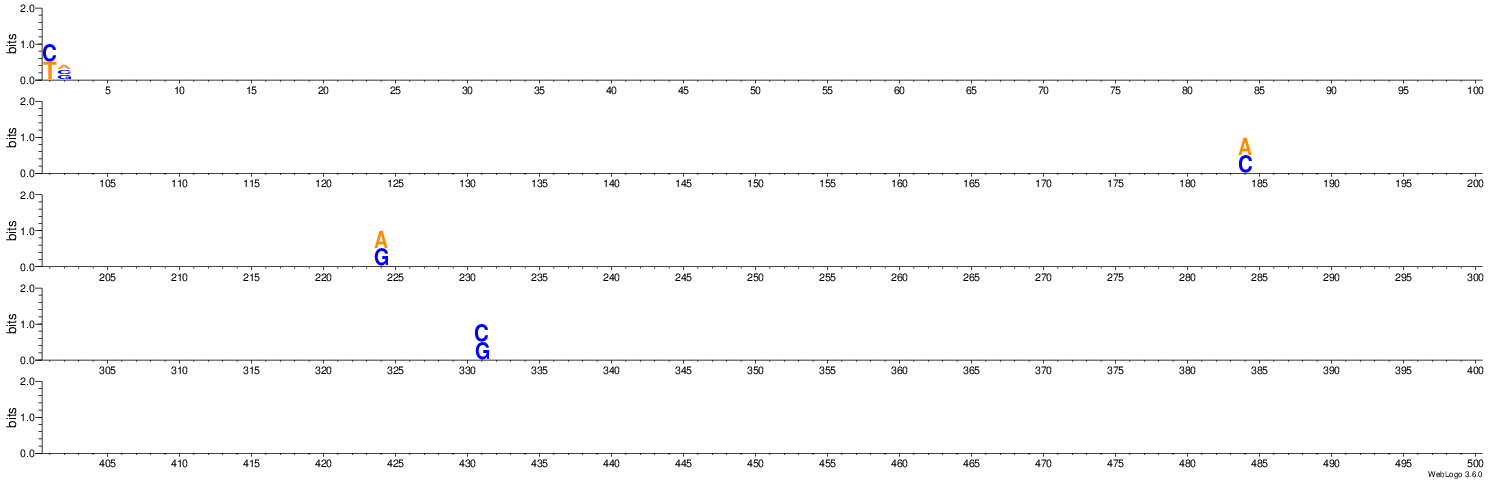

In [15]:
from IPython.display import Image

from weblogolib import *
from io import StringIO

print("Sequence Length", len(sequence))
seqs = ""
# seqs = ">\n"+sequence+"\n"
for (chrom, position), alleles in variants.items():
    for allele in alleles:
        seq = ["-"]*len(sequence)
        seq[start - position] = allele
        seqs += ">\n" + "".join(seq) + "\n"

sequences = read_seq_data(StringIO(seqs))
data = LogoData.from_seqs(sequences)
options = LogoOptions()
options.title = 'A Logo Title'
options.scale_width = False
options.logo_end = 500
options.stacks_per_line = 100
formatting = LogoFormat(data, options)

png = png_formatter(data, formatting)
Image(png)
